# Summary
In this notebook, I look up the elevation at the location with a fire's given latitude and longitude using a raster query tool called "gdallocationinfo."

<a id="prereqs"></a>
# 1. Required Tools and Data
The U.S. Geological Survey assembles elevation data with 100-meter resolution. It is stored as a TIFF file, which requires a specific utility to retrieve the elevation at the given coordinates. The [gdallocationinfo utility](https://www.gdal.org/gdallocationinfo.html) is a command line tool that "provide a mechanism to query information about a pixel given its location in one of a variety of coordinate systems."  

The Elevation maps are stored in four separate files: [the conterminous US](https://www.sciencebase.gov/catalog/item/581d0539e4b08da350d52552), [Alaska](https://www.sciencebase.gov/catalog/item/581d0539e4b08da350d52557), [Hawaii](https://www.sciencebase.gov/catalog/item/581d053ae4b08da350d5255b), and [Puerto Rico](https://www.sciencebase.gov/catalog/item/581d053ae4b08da350d5255f).

# 2. Imports

In [1]:
import os
import pandas as pd 
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()



# 3. Generic Version of get_elevation
To use the gdallocationinfo utility within python, you need to use the subprocess package. Credits to [user20408](https://gis.stackexchange.com/questions/118397/store-result-from-gdallocationinfo-as-variable-in-python)  for coming up with the correct syntax. 

In [2]:
def gen_get_elevation(lon, lat, tiff_path):
    '''return elevation from coordinates and the file path to the relevant TIFF file
    Requires gdallocation tool https://www.gdal.org/gdallocationinfo.html'''
    return os.popen(f'gdallocationinfo -valonly -wgs84 {tiff_path} {lon} {lat}')\
                        .read().strip()

#gdallocationinfo defaults to an empty string if can't find location in TIFF


# 4. Demo Application


Since the elevation data is split into 4 TIFF files, I needed to take the corresponding subset of rows and apply the function each time. It was simpler for me to feed the whole row of the dataframe and edit in the right file path into the function directly each time I ran the script, so that's what I did. With all those done, the 4 subsets were merged back together with pd.concat.

In [3]:
# load sample data
fires = pd.read_pickle('lean_fires.pkl') 
# filter for sample subset
alaska = fires[fires['STATE'] == 'AK']
print(len(alaska))

328


In [4]:
# df.apply version  
def df_get_elevation(row):
    '''return elevation in meters from coordinates
    Requires gdallocation tool https://www.gdal.org/gdallocationinfo.html'''
    lon = row['LONGITUDE']
    lat = row['LATITUDE']
    return os.popen(f'gdallocationinfo -valonly -wgs84 /home/douglas/USGS\ Conterminous\ US/alaska/elevaki0100a.tif {lon} {lat}').read().strip()

In [5]:
start = time.time()
alaska['Elevation'] = alaska.apply(df_get_elevation, axis=1)
end = time.time()
print('Apply execution time per row=', (end - start)/len(alaska))
# start = time.time()
# alaska.to_pickle('alaska_with_elevation.pkl')
# end = time.time()
# print('Pickling execution time=', end - start)

Apply execution time per row= 0.10201887241223963


/home/douglas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
alaska[['LATITUDE', 'LONGITUDE', 'Elevation']].head()

,LATITUDE,LONGITUDE,Elevation
377784,61.066670,-149.766700,290
378635,64.833340,-147.850000,124
1652054,62.055888,-151.616888,158
379682,64.848390,-148.047900,246
1361542,64.766670,-149.566665,91


# 4. EDA On Full Elevation Data

In [7]:
# load a full data set 
full = pd.read_pickle('dec_4_fires_joined_3weather_days.pkl')

In [8]:
#top 10 elevations overall
full['Elevation'].value_counts()[:10]

3     17556
6     12163
5     10878
4     10640
2     10530
7     10304
8      9872
1      8306
9      8100
25     7185
Name: Elevation, dtype: int64

In [9]:
# Elevation was in str format
full['Elevation'] = full['Elevation'].astype('int')

In [10]:
%time full.groupby('FIRE_SIZE_CLASS')['Elevation'].describe()

CPU times: user 4.48 s, sys: 1.13 s, total: 5.6 s
Wall time: 3.96 s


,count,mean,std,min,25%,50%,75%,max
FIRE_SIZE_CLASS,,,,,,,,
A,666904.0,749.409936,795.410740,-84.0,101.0,368.0,1363.0,4109.0
B,939370.0,366.200618,514.925558,-80.0,69.0,169.0,392.0,3946.0
C,220076.0,345.633290,471.033390,-71.0,67.0,170.0,383.0,3659.0
D,28427.0,564.598656,601.299032,-51.0,117.0,337.0,826.5,3354.0
E,14107.0,752.604948,685.289924,-58.0,214.0,500.0,1251.0,3718.0
F,7786.0,964.941176,724.881291,-1.0,313.0,881.5,1524.0,3111.0
G,3773.0,1081.395706,735.498438,-13.0,391.0,1090.0,1615.0,3601.0


Text(0,0.5,'Fire size class')

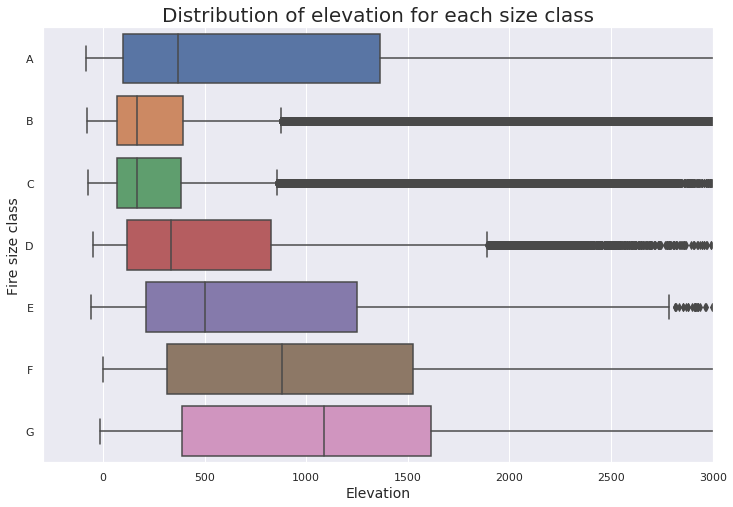

In [11]:
plt.figure(figsize=(12,8))
sns.boxplot(x='Elevation', y='FIRE_SIZE_CLASS', data=full, order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.title('Distribution of elevation for each size class', fontsize=20)
plt.xlim(right= 3000)
plt.xlabel('Elevation', fontsize=14)
plt.ylabel('Fire size class', fontsize=14)

The wide distributions make it difficult to draw any conclusions from  elevations alone. However, there does seem to be a slight upward trend as fires get larger and we'll see if it adds any signal when combined with the other features of the data. 